In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import covid_19_shared





In [2]:
Country = "US"
# Country = "Italy"
# Country = "India"
# cv_data = covid_19_shared.loadJHUData(Country, True)
# Country = "Australia"
cv_data = covid_19_shared.load_JHU_Data_global(Country)


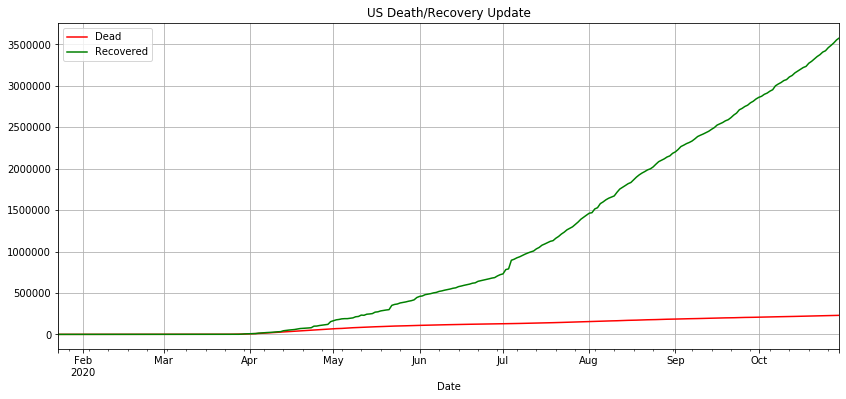

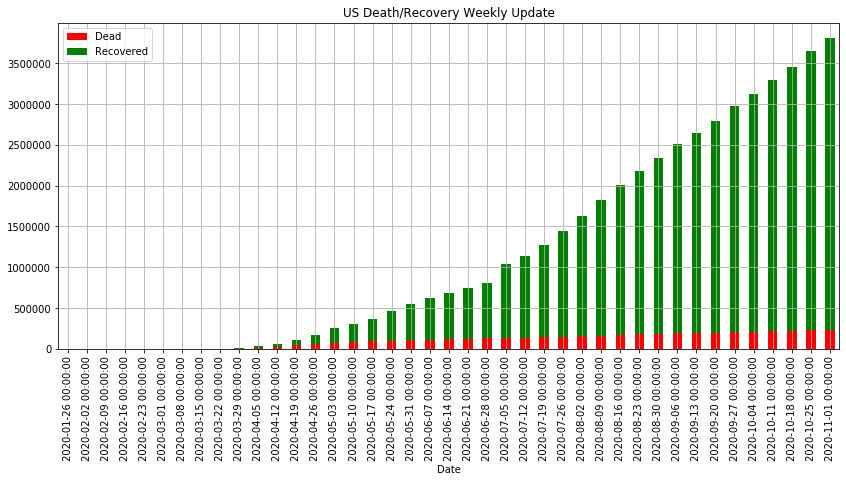

In [3]:
dead = cv_data.Dead
recovered = cv_data.Recovered

df = (pd.DataFrame({"Dead":dead
                   , "Recovered" : recovered
                  }
                  , index=cv_data.index)
          .resample("1D")
          .max()
     )

df.plot(kind='line'
        , figsize=(14, 6)
        , legend=True
        , label="Completed Cases"
        , grid = True
        , color = ['red', 'green']
        , title = f"{Country} Death/Recovery Update"
        )
# Weekly
df.resample("1W").max().plot(kind='bar'
        , stacked=True
        , figsize=(14, 6)
        , legend=True
        , label="Completed Cases"
        , grid = True
        , align = 'center'
        , color = ['red', 'green']
        , title = f"{Country} Death/Recovery Weekly Update"
        )
# plt.gcf().autofmt_xdate()
plt.show()



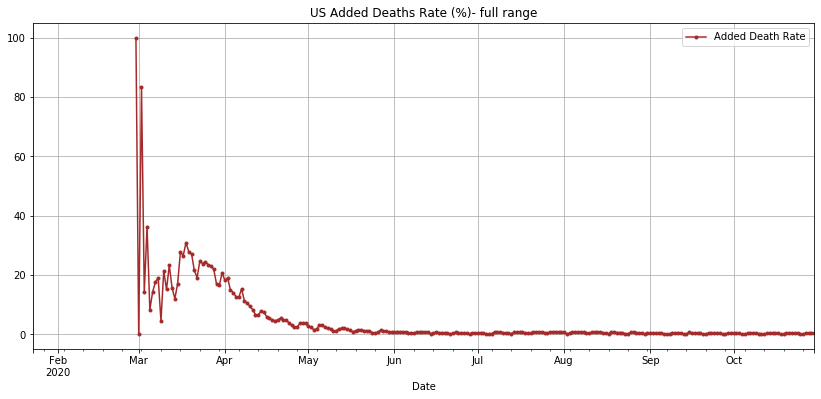

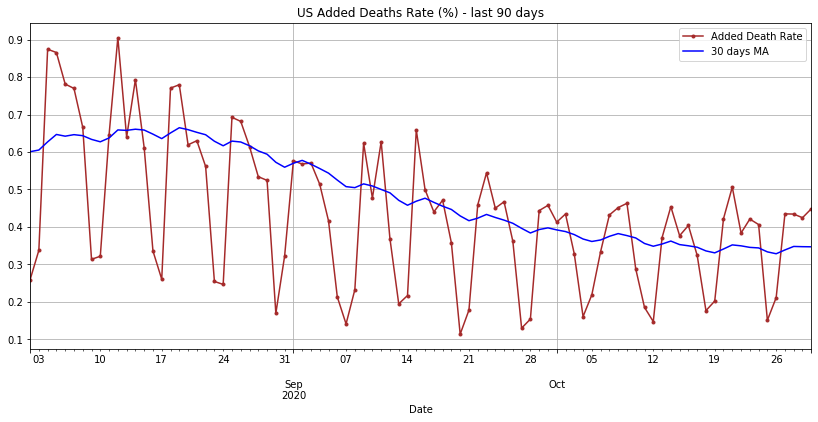

In [4]:
def growth_pcnt(ser): 
    return (ser - ser.shift(1)) / ser * 100

df = pd.DataFrame({"Added Death Rate" : growth_pcnt(cv_data.Dead)}, index=cv_data.index)
df.plot(
    kind = 'line'
    , title = f"{Country} Added Deaths Rate (%)- full range"
    , figsize=(14, 6)
    , grid = True
    , style = '.-'
    , color = ['brown']
)
# plt.show()

df_data = df
df_ma_data = df.rolling(30).mean().dropna()


df = pd.DataFrame( {
    "Added Death Rate" : df_data["Added Death Rate"]
    , "30 days MA" : df_ma_data["Added Death Rate"]
}, index = df_data.index)


df[-90:].plot(
    kind = 'line'
    , title = f'{Country} Added Deaths Rate (%) - last 90 days'
    , figsize=(14, 6)
    , grid = True
    , style = ['.-', '-']
    , color = ['brown', "blue"]
    , legend = True
)
plt.show()

                   0
Date                
2020-10-28  6.078367
2020-10-29  6.044316
2020-10-30  6.031452


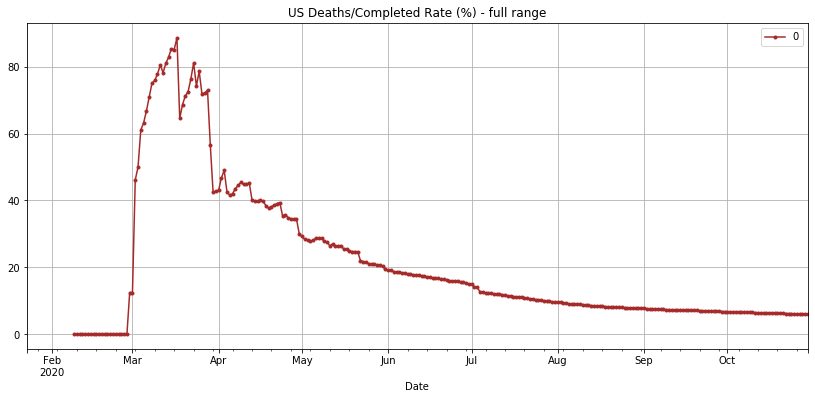

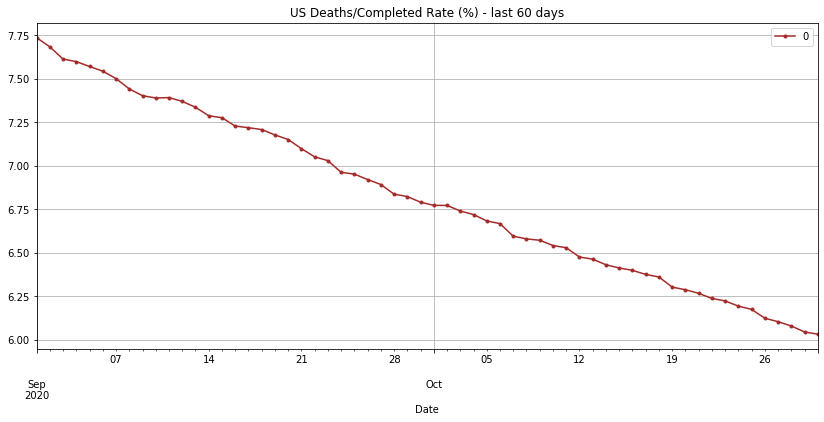

In [5]:
# Death rate in completed cases
death_rate = pd.DataFrame(dead / (cv_data.Dead + cv_data.Recovered) * 100.0
                          , index=cv_data.index)
death_rate.plot(
    kind = 'line'
    , title = f'{Country} Deaths/Completed Rate (%) - full range'
    , figsize=(14, 6)
    , grid = True
    , style = '.-'
    , color = ['brown']
)
print(death_rate.tail(3))
plt.show()
# last 60 days
death_rate[-60:].plot(
    kind = 'line'
    , title = f'{Country} Deaths/Completed Rate (%) - last 60 days'
    , figsize=(14, 6)
    , grid = True
    , style = '.-'
    , color = ['brown']
)
plt.show()


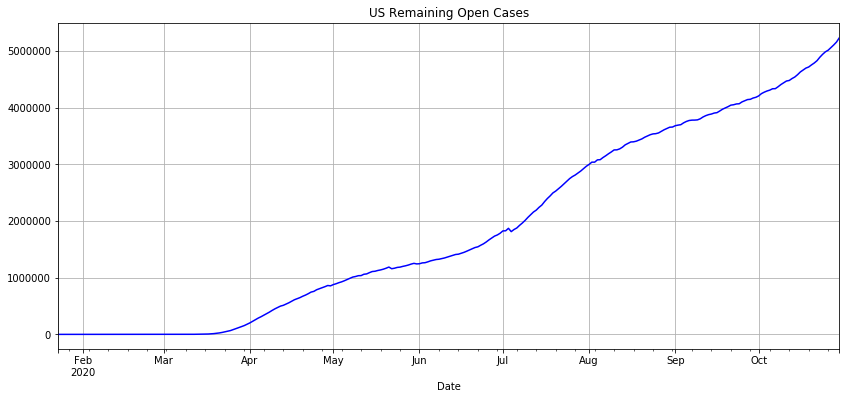

In [6]:
# Remaining open cases
df = (cv_data.Confirmed - cv_data.Dead - cv_data.Recovered).dropna()
df.plot(
    title=f'{Country} Remaining Open Cases'
    , figsize=(14, 6)
    , grid = True
    , color = ['blue']
)


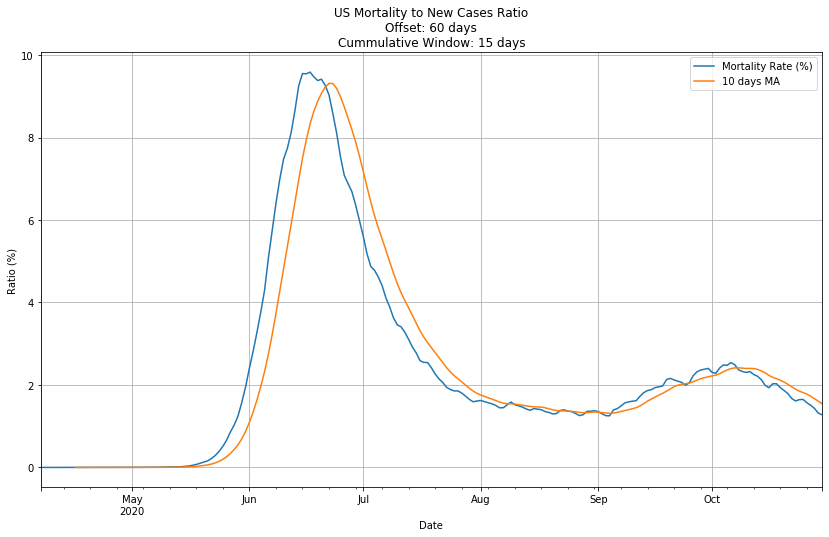

Date
2020-10-26    1.569599
2020-10-27    1.507941
2020-10-28    1.430952
2020-10-29    1.319920
2020-10-30    1.277613
dtype: float64


In [7]:
# New Cases -> Deathes Correlation

def mortalityToNewCasesRatio(cumm_wnd_days : int
                             , offset_days : int):
    confirmed = cv_data.Confirmed
    dead = cv_data.Dead
    # accumulate total confirmed during that "cummDaysWindow" days
    cumm_conf = confirmed - confirmed.shift(cumm_wnd_days)

    # death accumulate for same windows but "offset_days" later
    deadOffset = dead.shift(offset_days)
    cummDead = deadOffset -  deadOffset.shift(cumm_wnd_days)

    res = cummDead * 100 / cumm_conf
    return res

    
def plot_cases_mortality_chart(**kwargs):
    cumm_wnd_days = kwargs["window_size"]
    days_shift = kwargs["offset_days"]
    maDays = kwargs["ma_days"] if "ma_days" in kwargs else 5

    ratio = mortalityToNewCasesRatio(cumm_wnd_days
                                    , days_shift).dropna()
    ratio.plot(title=f'{Country} Mortality to New Cases Ratio\n' 
               + f"Offset: {days_shift} days\n"
               + f"Cummulative Window: {cumm_wnd_days} days"
           , figsize = (14, 8)
           , grid = True
           , legend = True
           , label="Mortality Rate (%)"
           )

    ratio.rolling(maDays).mean().plot(grid=True
                                  , label="{} days MA".format(maDays)
                                  , legend=True)
    plt.ylabel("Ratio (%)")
    plt.show()
    print(ratio.tail(5))

# --- main
# # for cum_wnd_days in [15, 20, 30]:
# #     plot_correlation_chart(confirmed, dead, cum_wnd_days)

cum_wnd_days = 15
offset_days = 60
plot_cases_mortality_chart(window_size=cum_wnd_days
                           , offset_days=offset_days 
                           , ma_days=10)




Date
2020-10-26    28744.0
2020-10-27    45435.0
2020-10-28    46895.0
2020-10-29    51354.0
2020-10-30    74175.0
dtype: float64


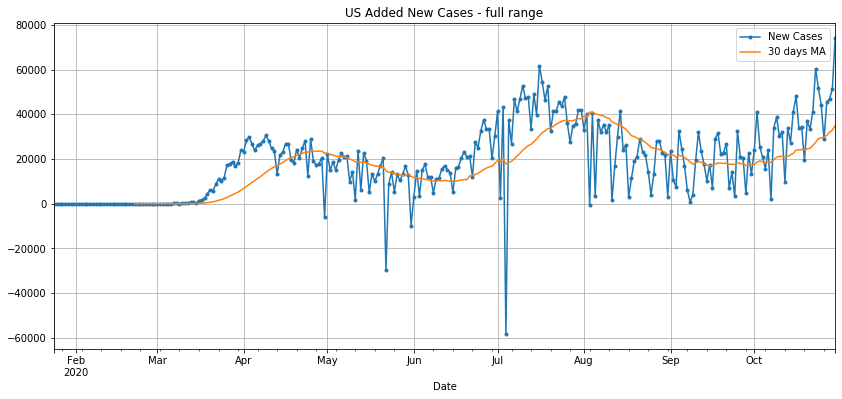

Deaths Per Day
Date
2020-10-26     477.0
2020-10-27     986.0
2020-10-28     989.0
2020-10-29     971.0
2020-10-30    1030.0
Name: Dead, dtype: float64


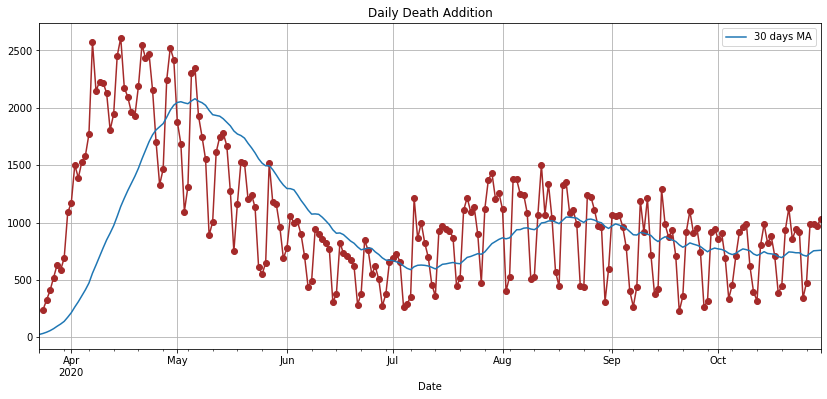

In [8]:
confirmed_new = (cv_data.Confirmed - cv_data.Confirmed.shift(1)).dropna()
dead_new = (cv_data.Dead - cv_data.Dead.shift(1)).dropna()
recovered_new = (cv_data.Recovered - cv_data.Recovered.shift(1)).dropna()

deaths_new_pcnt = growth_pcnt(cv_data.Dead)
confirmed_new_pcnt = growth_pcnt(cv_data.Confirmed)

growth = pd.Series((confirmed_new - (dead_new + recovered_new)).array
                   , index=cv_data.index[1:]).dropna()

print(growth.tail(5))

growth.plot(figsize=(14, 6)
            , title=f'{Country} Added New Cases - full range'
            , legend=True
            , label="New Cases"
            , style='.-')
growth.rolling(30).mean().plot(grid=True, legend=True, label="30 days MA")
plt.show()



df_data = dead_new[60:].dropna()
df_ma = dead_new[30:].rolling(30).mean().dropna()

print("Deaths Per Day\n" + str(df_data.tail()))
df_data.plot(
    title="Daily Death Addition"
    , figsize=(14, 6)
    , grid = True
    , color = ['brown']
    , style = '-o'
)
df_ma.plot(grid=True, legend=True, label="30 days MA")
plt.show()


Deaths Per Day
            Daily Deaths Addition
Date                             
2020-10-26                  477.0
2020-10-27                  986.0
2020-10-28                  989.0
2020-10-29                  971.0
2020-10-30                 1030.0


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

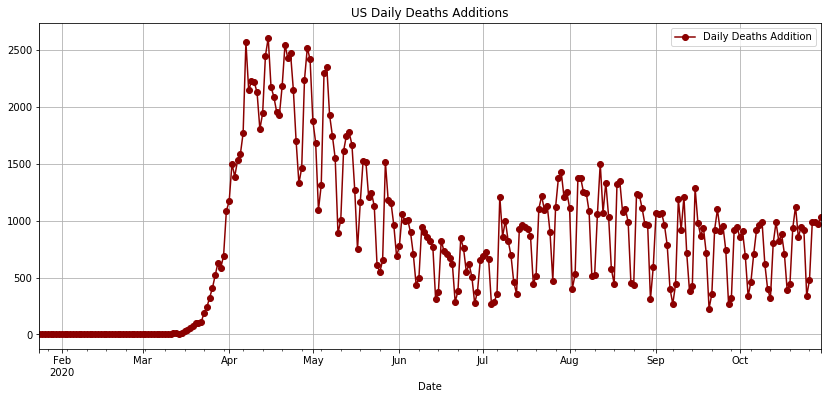

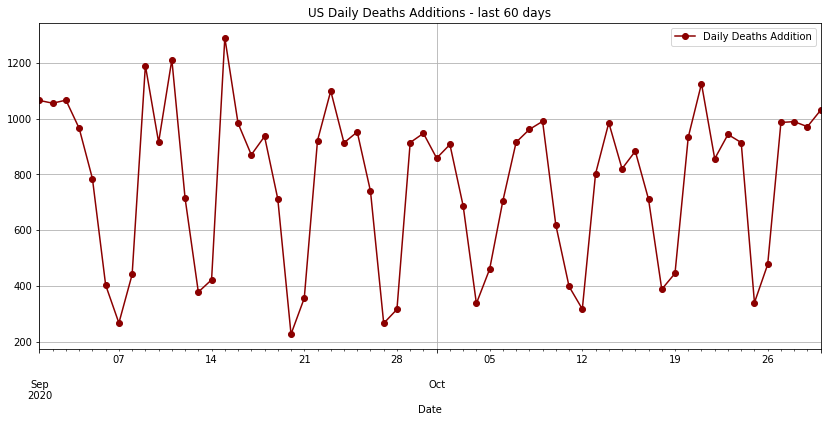

In [9]:
plt.figure(figsize = (15,10))

df = pd.DataFrame({"Daily Deaths Addition" :  dead_new}, index=dead_new.index)
plt.figure(figsize = (15,10))

print("Deaths Per Day\n" + str(df.tail()))
df.plot(title = f'{Country} Daily Deaths Additions'
        , grid = True
        , legend = True
        , style = '-o'
        , figsize=(14, 6)
        , color = ["darkred"]
       )
plt.show()
df[-60:].plot(title = f'{Country} Daily Deaths Additions - last 60 days'
        , grid = True
        , legend = True
        , style = '-o'
        , figsize=(14, 6)
        , color = ["darkred"]
       )
plt.show()

New Cases Per Day
            Daily Cases Addition
Date                            
2020-10-26               66798.0
2020-10-27               73632.0
2020-10-28               78358.0
2020-10-29               88521.0
2020-10-30               99321.0


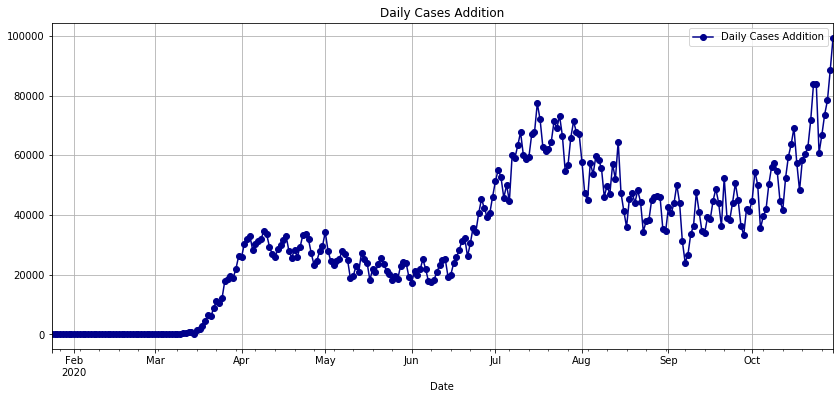

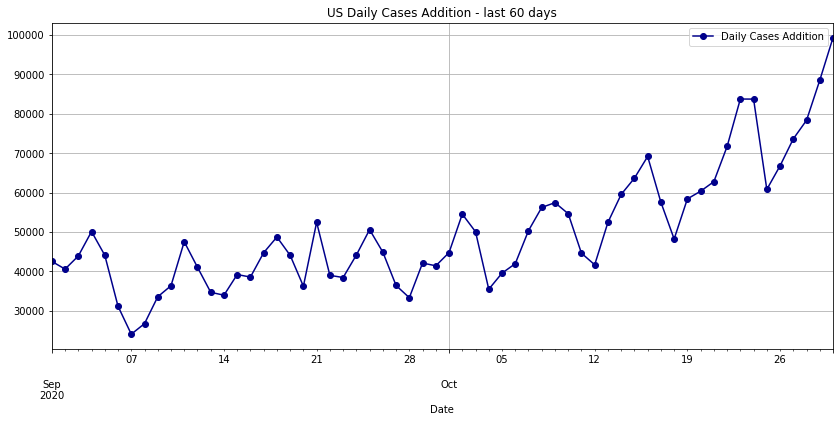

In [10]:
df = pd.DataFrame({"Daily Cases Addition" : confirmed_new}, index=dead_new.index)
print("New Cases Per Day\n" + str(df.tail()))
df.plot(title = "Daily Cases Addition"
        , grid = True
        , legend = True
        , style = '-o'
        , figsize=(14, 6)
        , color = ["darkblue"]
       )
plt.show()

df[-60:].plot(title = f"{Country} Daily Cases Addition - last 60 days"
        , grid = True
        , legend = True
        , style = '-o'
        , figsize=(14, 6)
        , color = ["darkblue"]
       )
plt.show()

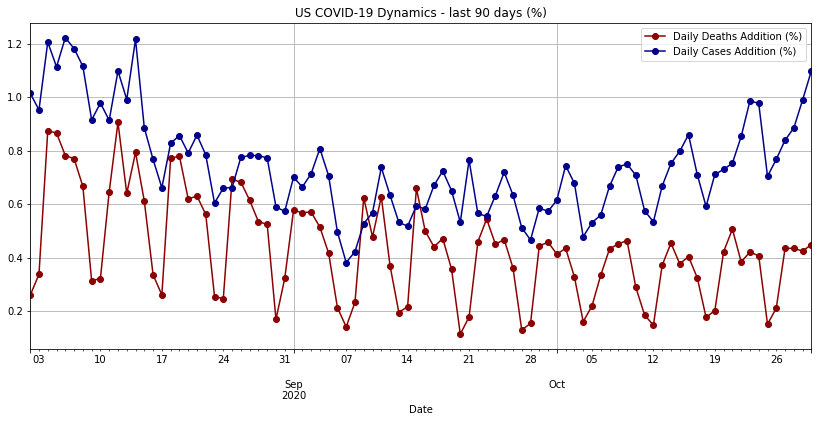

In [11]:
df = pd.DataFrame({"Daily Deaths Addition (%)" : deaths_new_pcnt
                      , "Daily Cases Addition (%)" : confirmed_new_pcnt}
                  , index=deaths_new_pcnt.index)['2020-03-01':]

# df.plot(title = "COVID-19 Dynamics (%)"
#         , grid = True
#         , legend = True
#         , style = '-o'
#         , figsize=(14, 6)
#         , color = ["darkred", "darkblue"]
#        )

# Last 90 days

df = df[-90:]
df.plot(title = f'{Country} COVID-19 Dynamics - last 90 days (%)'
        , grid = True
        , legend = True
        , style = '-o'
        , figsize=(14, 6)
        , color = ["darkred", "darkblue"]
       )


In [12]:
%%script false --no-raise-error # do not run it 

def calcCorrelation(cumm_wnd_days : int
                    , days_shift : int):
    confirmed = cv_data.Confirmed
    dead = cv_data.Dead
    # accumulate total confirmed during that "cumm_wnd_days" days
    cumm_conf = (confirmed - confirmed.shift(cumm_wnd_days)).shift(days_shift).dropna()

    # death accumulate for same windows but "offsetDays" later
    dead_shift = dead.shift(days_shift)
    cumm_dead = (dead_shift -  dead_shift.shift(cumm_wnd_days)).dropna()

    ratio = (cumm_dead * 100 / cumm_conf).dropna()
    
    corr=ratio.corr(cumm_conf)
    return corr

def correlation(cum_wnd_days: int):
    num_observ_days = len(cv_data.index) - 2 *cum_wnd_days
    after_days_arr=range(1, num_observ_days)
    
    corr_arr = [calcCorrelation(cum_wnd_days, after_days) 
               for after_days in after_days_arr]
    return pd.Series(corr_arr)
    
def plot_correlation_chart(corr : pd.DataFrame
                          , cum_wnd_days: int):
    corr.plot(figsize=(14, 8)
             , title = f'{Country} Mortality/New Cases Day Shift correlation\nCumm Window = {cum_wnd_days} days"
             , legend = False, label="Correlation") 
    plt.ylabel("Correlation")
    plt.xlabel("Day Shift")
    plt.show()


def max_correlation_by_window(cumm_wnd_days):
    corr = correlation(cumm_wnd_days).dropna()
    corr_days=corr.idxmax()
    corr_val=corr[corr_days]
    return (cumm_wnd_days, corr_days, corr_val)
    
    
data = [max_correlation_by_window(cumm_wnd_days) for cumm_wnd_days in range(1, 60)]
df = pd.DataFrame(data, columns=["WndDays", "ShiftDays", "CorrValue"])

max_corr_idx = df.CorrValue.idxmax()
wnd_size=df.WndDays[max_corr_idx]
shift_days=df.ShiftDays[max_corr_idx]
print(f"max_corr_value={df.CorrValue[max_corr_idx]} max_wnd_days={df.WndDays[max_corr_idx]} max_shift_days={df.ShiftDays[max_corr_idx]}") 
plot_correlation_chart(correlation(wnd_size).dropna(), wnd_size)
plot_cases_mortality_chart(window_size=wnd_size
                           , offset_days=shift_days # taking maximal correlation value
                           , ma_days=10)




corr = correlation(15)
plot_correlation_chart(corr, 15)
plot_cases_mortality_chart(window_size=15
                           , offset_days=corr.idxmax() # taking maximal correlation value
                           , ma_days=10)



In [13]:
%%script false --no-raise-error    
# ---  D O N ' T   R U N

'''
Calculate predicted mortality
We'll extrapolate the curve to the point where all confirmed cases
will be completed (assuming no new cases)
'''
dead = cv_data.Dead
recovered = cv_data.Recovered

df = pd.DataFrame({"Dead":dead
                   , "Recovered" : recovered
                  }
                  , index=cv_data.index
     )

dates = pd.date_range(cv_data.index[0], periods=500, freq='1D')

df.index = dates
df

# df.plot(kind='line'
#         , figsize=(14, 6)
#         , legend=True
#         , label="Completed Cases"
#         , grid = True
#         , color = ['red', 'green']
#         , title = "Death/Recovery Update"
#         )




# extrapolate with curve fitting
